In [1]:
import torch
from matplotlib import pyplot as plt
from the_well.data import WellDataset
from torch.utils.data import DataLoader
import numpy as np

from dataclasses import dataclass
from datasets import load_dataset

from torchvision import transforms
import torch

from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F
from matplotlib import pyplot as plt
from accelerate import notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from PIL import Image
import glob
import numpy as np
from torchvision.transforms import InterpolationMode

In [2]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-upscaling-128"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



config = TrainingConfig()

In [8]:

dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [9]:
def pad_to_square(image):
    # Get the current dimensions
    width, height = image.size
    
    # Find the maximum dimension to make it square
    max_dim = max(width, height)
    
    # Calculate padding
    pad_left = (max_dim - width) // 2
    pad_right = max_dim - width - pad_left
    pad_top = (max_dim - height) // 2
    pad_bottom = max_dim - height - pad_top
    
    # Apply padding (using 0 for black padding, you can change this value)
    padding = (pad_left, pad_top, pad_right, pad_bottom)
    return transforms.Pad(padding, fill = 255, padding_mode = 'constant')(image)

preprocess = transforms.Compose([
    transforms.Lambda(pad_to_square),  # Custom function to pad to square
    transforms.Resize((config.image_size, config.image_size)),
])

# Define separate preprocessing for high-res and low-res images
high_res_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

low_res_preprocess_new_dim = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: F.avg_pool2d(x, kernel_size=2)),
    transforms.Normalize([0.5], [0.5]),
])

low_res_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: F.avg_pool2d(x, kernel_size=2)),
    transforms.Resize(
        (config.image_size, config.image_size),  
        interpolation=InterpolationMode.NEAREST_EXACT 
    ),
    transforms.Normalize([0.5], [0.5]),
])

def transform(examples):
    # Process each image to create both high-res and low-res versions
    high_res_images = []
    low_res_images = []
    low_res_images_new_dim = []
    for image in examples['image']:
        pre_img = preprocess(image.convert("RGB"))
        high_res_images.append(high_res_preprocess(pre_img))
        low_res_images.append(low_res_preprocess(pre_img))
        low_res_images_new_dim.append(low_res_preprocess_new_dim(pre_img))
    
    return {
        "high_res_images": high_res_images,
        "low_res_images": low_res_images,
        'low_res_images_new_dim': low_res_images_new_dim
    }

dataset.set_transform(transform)

In [19]:
dataset2= WellDataset(
    well_base_path="./the_well/datasets/",
    well_dataset_name="active_matter",
    well_split_name="train"
)

avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

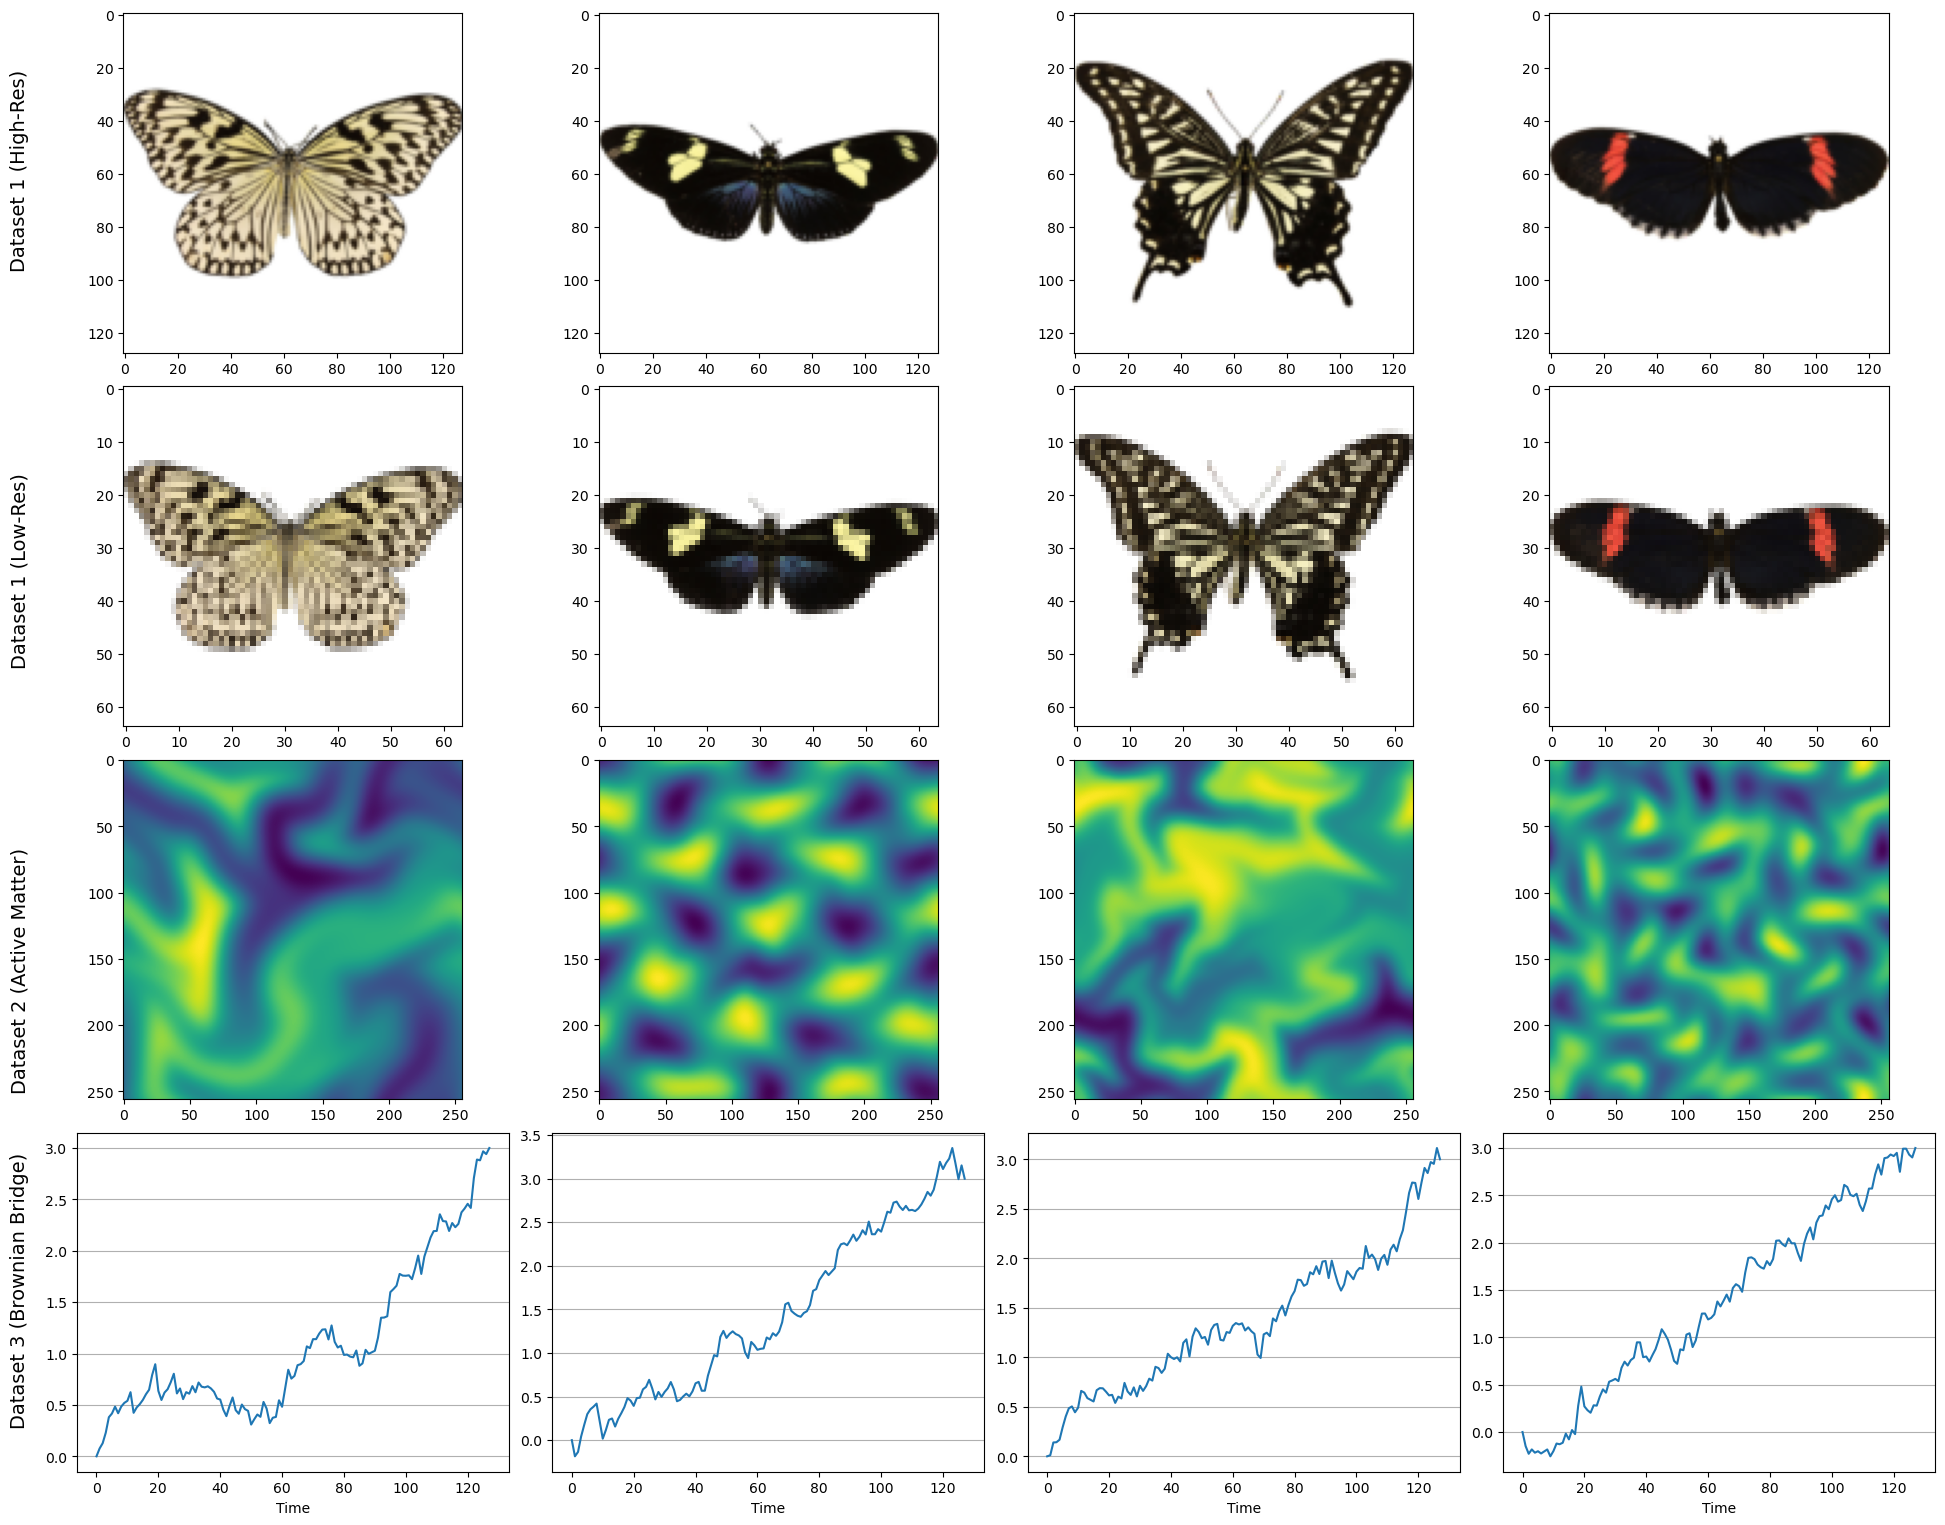

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib

plt.style.use('default')
matplotlib.rcParams['figure.figsize'] = (20, 16)

# Helper function to reverse normalization
def undo_normalize(tensor):
    return (tensor + 1) / 2

# Define the Brownian Bridge dataset (already given in your code)
class BrownianBridgeDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=128, end_point=3.0):
        self.data = torch.zeros(num_samples, seq_len)
        times = torch.linspace(0, 1, seq_len)
        
        for i in range(num_samples):
            dW = torch.randn(seq_len-1) / np.sqrt(seq_len)
            W = torch.cumsum(dW, 0)
            W = torch.cat([torch.tensor([0.0]), W])
            
            t = times
            bridge = W - t * W[-1] + t * end_point
            
            self.data[i] = bridge
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {"X": self.data[idx]}


def create_dataset_visualization_grid(dataset):
    # Create the main figure with 4x4 grid
    fig, axs = plt.subplots(4, 4, figsize=(20, 16))
    
    # Dataset 1 - High Res and Low Res Images (Rows 1 and 2)
    high_res_images = dataset[:4]["high_res_images"]
    low_res_images = dataset[:4]["low_res_images_new_dim"]
    
    # Dataset 1 - High Resolution Images (Row 1)
    for i in range(4):
        axs[0, i].imshow(undo_normalize(high_res_images[i].permute(1, 2, 0)))
        #axs[0, i].set_axis_off()
    
    # Dataset 1 - Low Resolution Images (Row 2)
    for i in range(4):
        axs[1, i].imshow(undo_normalize(low_res_images[i].permute(1, 2, 0)))
        #axs[1, i].set_axis_off()
    
    # Dataset 2 - Well Dataset Images (Row 3)
    well_images = [dataset2[i] for i in torch.randint(len(dataset2), (4,))]

    for i in range(4):
        img = well_images[i]['input_fields'].squeeze(0).permute(2, 0, 1)[0, :, :]
        axs[2, i].imshow(img, cmap='viridis')
        #axs[2, i].set_axis_off()
    
    # Dataset 3 - Brownian Bridge (Row 4)
    bridge_dataset = BrownianBridgeDataset(num_samples=10, seq_len=128)
    
    for i in range(4):
        sample = bridge_dataset[i]["X"]
        axs[3, i].plot(sample)
        axs[3, i].set_xlabel("Time")
        axs[3, i].grid(True)
        axs[3, i].grid(True, axis='x', alpha=0)  # Hide horizontal grid lines
    
    # Add dataset labels to the left side of each row
    fig.text(0.03, 0.85, 'Dataset 1 (High-Res)', fontsize=14, rotation=90, va='center')
    fig.text(0.03, 0.60, 'Dataset 1 (Low-Res)', fontsize=14, rotation=90, va='center')
    fig.text(0.03, 0.35, 'Dataset 2 (Active Matter)', fontsize=14, rotation=90, va='center')
    fig.text(0.03, 0.15, 'Dataset 3 (Brownian Bridge)', fontsize=14, rotation=90, va='center')
    
    plt.tight_layout(rect=[0.04, 0, 1, 0.96])  # Adjust for the suptitle and dataset labels
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce space between subplots
    plt.savefig('dataset_visualization_grid.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Execute the function to create and display the visualization grid
visualization_grid = create_dataset_visualization_grid(dataset)